In [107]:
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns
from IPython.display import Image
from statistics import mean
from IPython.core.display import splitext
import scipy.stats as stats
from math import e
import ast
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score,classification_report,ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
import random
from sklearn.cluster import KMeans
df = pd.read_csv('titles.csv')

Pre proccecing stage:

In [108]:
#fill NaN values in 0 value

#fill NaN values in mean for each colom
df['imdb_score'].fillna(np.mean(df['imdb_score']),inplace=True)
df['imdb_votes'].fillna(np.mean(df['imdb_votes']),inplace=True)
df['tmdb_popularity'].fillna(np.mean(df['tmdb_popularity']),inplace=True)
df['tmdb_score'].fillna(np.mean(df['tmdb_score']),inplace=True)

#drop coloms
df.drop("id",axis=1,inplace=True)
df.drop("imdb_id",axis=1,inplace=True)
df.drop("age_certification",axis=1,inplace=True)
df.drop("title",axis=1,inplace=True)
df.drop("description",axis=1,inplace=True)
df.drop('seasons',axis=1,inplace=True)
# df.drop('production_countries',axis=1,inplace=True)
#change value of genres and production_countries
def num_of_element(column_name):
    dic_for_column ={}
    i=0
    count=0
    for arr in df[column_name]:
        dic_for_column[i] = arr.count(',') +1
        i+=1
    column_array = []
    for val in dic_for_column.values():
        column_array.append(val)
    return column_array
genres_dict ={
    "documentation":1,
    "drama":2,
    "crime":3,
    "action":4,
    "thriller":5,
    "european":6,
    "fantasy":7,
    "action":8,
    "comedy":9,
    "war":10,
    "romance":11,
    "western":12,
    "history":13,
    "music":14,
    "family":15,
    "horror":16,
    "scifi":17,
    "animation":18,
}

df['genres'] = np.array(num_of_element('genres'))
df['production_countries'] = np.array(num_of_element('production_countries'))
df

,type,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,1945,51,1,1,6.510861,23439.382474,0.600000,6.829175
1,MOVIE,1976,114,2,1,8.200000,808582.000000,40.965000,8.179000
2,MOVIE,1972,109,4,1,7.700000,107673.000000,10.010000,7.300000
3,MOVIE,1975,91,3,1,8.200000,534486.000000,15.461000,7.811000
4,MOVIE,1967,150,2,2,7.700000,72662.000000,20.398000,7.600000
...,...,...,...,...,...,...,...,...,...
5845,MOVIE,2021,100,2,1,6.800000,45.000000,1.466000,6.829175
5846,MOVIE,2021,134,1,1,7.700000,348.000000,22.637925,6.829175
5847,MOVIE,2021,90,1,1,3.800000,68.000000,26.005000,6.300000
5848,MOVIE,2021,37,1,1,6.510861,23439.382474,1.296000,10.000000


In [109]:
# def createArrOfGeners(df):
#   new_col=[]
#   for i in df["genres"]:
#     new_col.append(i)
#   return new_col

# flattened_array = list(set(word for sublist in createArrOfGeners(df) for word in ast.literal_eval(sublist)))


# dictionary = {index: value for index, value in enumerate(flattened_array)}
# print(dictionary)

Function for Pre-Proccecing

In [110]:


def z_score(arr):
  myarray=np.array(arr)
  newarr = stats.zscore(myarray)
  return newarr

def equifreq(arr1, m):    
    a = len(arr1)
    n = int(a / m)
    freqArr ={}
    for i in range(m):
        arr = []
        for j in range(i * n, (i + 1) * n):
            if j >= a:
                break
            arr = arr + [arr1[j]]
        freqArr[str(i)] = arr
    return freqArr

def bin_boundaries(np_array): 
  minVal = min(np_array)
  maxVal = max(np_array)

  dist_to_min = np.abs(np_array - minVal)
  dist_to_max = np.abs(np_array - maxVal)
  
  return np.where(dist_to_min < dist_to_max, minVal, maxVal)
def createArrOfGeners(df):
  new_col=[]
  for i in df["genres"]:
    new_col.append(i)
  return new_col
def minmax(List):
  scaler = MinMaxScaler()
  col1 = scaler.fit_transform(List)
  newcol1 = np.array(col1)
  return newcol1
def pandas_entropy(column, base):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    return -(vc * np.log(vc)/np.log(base)).sum()

   

find entropy for each column:

In [111]:
for val in df.columns[1:]:
    print(f'entropy for column:{val} is :{pandas_entropy(df[val],2)}')

entropy for column:release_year is :3.8936276337969895
entropy for column:runtime is :7.071896434024163
entropy for column:genres is :2.372582407795767
entropy for column:production_countries is :0.6302177989639034
entropy for column:imdb_score is :5.482683412907622
entropy for column:imdb_votes is :11.118435199375979
entropy for column:tmdb_popularity is :12.022315894057535
entropy for column:tmdb_score is :5.925060387419471


best acurecy of DecisionTree on Random Forest

In [112]:
# scaler = MinMaxScaler()
# df2=df
# df2['production_countries'] = scaler.fit_transform(df2[['production_countries']])
# df2['imdb_score'] =scaler.fit_transform(df2[['imdb_score']])

# df2['genres'] = z_score(df2['genres'])
# df2['tmdb_popularity'] = z_score(df2['tmdb_popularity'])
# df2['tmdb_score'] =z_score(df2['tmdb_score'])

# max_tmdb_pop = str(int(df2['runtime'].max()))
# df2['runtime'] = df2['runtime']/(10**len(max_tmdb_pop))


# sorted_third_column = np.sort(df2['release_year'])
# bins = np.array_split(sorted_third_column, 4)
# sorted_third_column = [bin_boundaries(bin) for bin in bins]
# con = np.concatenate((sorted_third_column[0], sorted_third_column[1],sorted_third_column[2],sorted_third_column[3]))
# df2['release_year'] =con

# sorted_third_column1 = np.sort(df['imdb_votes'])
# bins1 = np.array_split(sorted_third_column1, 4)
# sorted_third_column1 = [bin_boundaries(bin) for bin in bins1]
# con1 = np.concatenate((sorted_third_column1[0], sorted_third_column1[1],sorted_third_column1[2],sorted_third_column1[3]))
# df2['imdb_votes'] =con1
# df2



Conclusion As soon as we put the best normalization from the decision tree model, in random forest we got an improvement in the model of 0.01%

The normalization step, and changing the column values

In [113]:
#apply function for each column

#test1

def random_normalization(column_name):
    chooise = random.randint(1,4)
    match chooise:
        case 1:#MINMAXSCALAR
            scaler = MinMaxScaler()
            df[column_name] = scaler.fit_transform(df[[column_name]])
            print(f'column :{column_name} was update by MINMAXSCALAR')
        case 2:#z-score
            df[column_name] = z_score(df[column_name])
            print(f'column :{column_name} was update by z-score')
        case 3:#bin-boindaries
            sorted_third_column = np.sort(df[column_name])
            bins = np.array_split(sorted_third_column, 4)
            sorted_third_column = [bin_boundaries(bin) for bin in bins]
            con = np.concatenate((sorted_third_column[0], sorted_third_column[1],sorted_third_column[2],sorted_third_column[3]))
            df[column_name] =con
            print(f'column :{column_name} was update by bin-boindaries')
        case 4:#decimal scaling
            max_tmdb_pop = str(int(df[column_name].max()))
            df[column_name] = df[column_name]/(10**len(max_tmdb_pop))
            print(f'column :{column_name} was update by decimal scaling')


for valus in df.columns[1:]:
    random_normalization(valus)

    



column :release_year was update by MINMAXSCALAR
column :runtime was update by decimal scaling
column :genres was update by bin-boindaries
column :production_countries was update by z-score
column :imdb_score was update by bin-boindaries
column :imdb_votes was update by bin-boindaries
column :tmdb_popularity was update by z-score
column :tmdb_score was update by bin-boindaries


In [114]:
df

,type,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,0.000000,0.051,1,-0.296613,1.5,5.0,-0.271954,0.5
1,MOVIE,0.402597,0.114,1,-0.296613,1.5,5.0,0.226161,0.5
2,MOVIE,0.350649,0.109,1,-0.296613,1.5,5.0,-0.155832,0.5
3,MOVIE,0.389610,0.091,1,-0.296613,1.5,5.0,-0.088565,0.5
4,MOVIE,0.285714,0.150,1,1.616491,1.5,5.0,-0.027641,0.5
...,...,...,...,...,...,...,...,...,...
5845,MOVIE,0.987013,0.100,10,-0.296613,9.6,2294231.0,-0.261267,10.0
5846,MOVIE,0.987013,0.134,10,-0.296613,9.6,2294231.0,0.000000,10.0
5847,MOVIE,0.987013,0.090,10,-0.296613,9.6,2294231.0,0.041551,10.0
5848,MOVIE,0.987013,0.037,10,-0.296613,9.6,2294231.0,-0.263365,10.0


split the data to train test

In [115]:

X = df.iloc[:,1:]
Y = df.iloc[:,:1]
class_names = ['MOVIE','SHOW']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)


In [116]:
X

,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0.000000,0.051,1,-0.296613,1.5,5.0,-0.271954,0.5
1,0.402597,0.114,1,-0.296613,1.5,5.0,0.226161,0.5
2,0.350649,0.109,1,-0.296613,1.5,5.0,-0.155832,0.5
3,0.389610,0.091,1,-0.296613,1.5,5.0,-0.088565,0.5
4,0.285714,0.150,1,1.616491,1.5,5.0,-0.027641,0.5
...,...,...,...,...,...,...,...,...
5845,0.987013,0.100,10,-0.296613,9.6,2294231.0,-0.261267,10.0
5846,0.987013,0.134,10,-0.296613,9.6,2294231.0,0.000000,10.0
5847,0.987013,0.090,10,-0.296613,9.6,2294231.0,0.041551,10.0
5848,0.987013,0.037,10,-0.296613,9.6,2294231.0,-0.263365,10.0


In [117]:
Y

,type
0,SHOW
1,MOVIE
2,MOVIE
3,MOVIE
4,MOVIE
...,...
5845,MOVIE
5846,MOVIE
5847,MOVIE
5848,MOVIE


In [118]:
X_train

,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
4862,0.987013,0.093,3,-0.296613,7.300000,17779.0,-0.141690,7.500000
3268,0.974026,0.034,3,-0.296613,6.510861,2819.0,1.226896,6.829175
5718,1.000000,0.060,3,-0.296613,9.600000,17779.0,-0.233243,10.000000
3384,0.974026,0.024,3,1.616491,6.510861,2819.0,-0.187584,6.829175
113,0.688312,0.119,1,-0.296613,5.900000,5.0,-0.011278,6.200000
...,...,...,...,...,...,...,...,...
3772,0.961039,0.097,3,-0.296613,6.510861,2819.0,-0.243794,7.500000
5191,0.987013,0.085,3,3.529594,7.300000,17779.0,0.481333,7.500000
5226,0.987013,0.089,3,-0.296613,7.300000,17779.0,0.729385,7.500000
5390,0.987013,0.000,3,-0.296613,7.300000,17779.0,-0.270782,7.500000


In [119]:
y_train

,type
4862,MOVIE
3268,SHOW
5718,MOVIE
3384,SHOW
113,MOVIE
...,...
3772,MOVIE
5191,MOVIE
5226,MOVIE
5390,SHOW


In [120]:
y_test.value_counts()

type 
MOVIE    764
SHOW     406
Name: count, dtype: int64

In [121]:
# creating DecisionTree
clf_pre = DecisionTreeClassifier(max_depth=2,random_state=42)
clf_pre.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

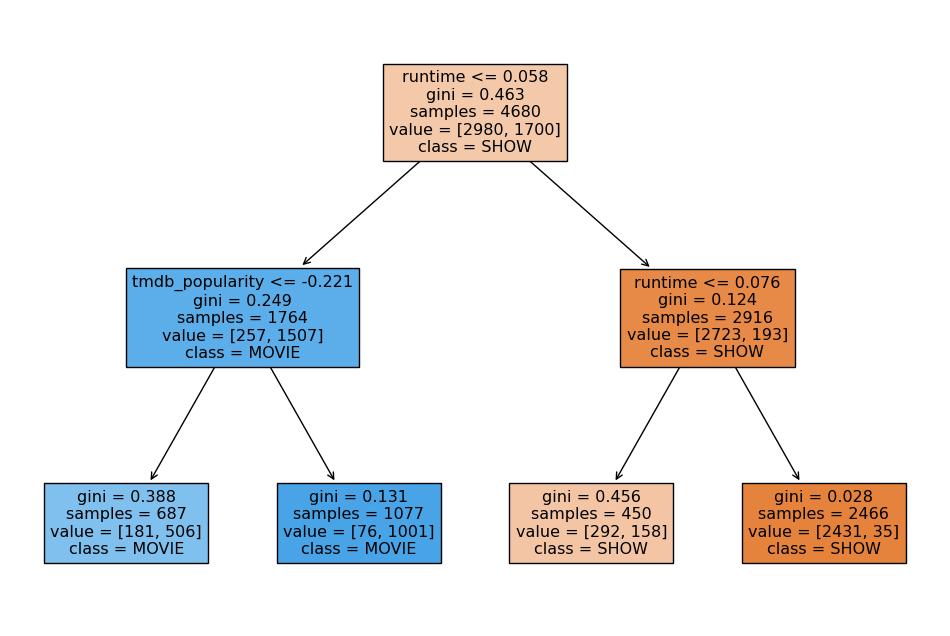

In [122]:
#plot of DecisionTree
plt.figure(figsize=(12,8))
plot_tree(clf_pre, filled=True, feature_names=X.columns, class_names=df['type'].unique())
plt.show()

In [123]:
y_pred_pre = clf_pre.predict(X_test)
accuracy_pre = accuracy_score(y_test, y_pred_pre)
print('Accuracy with pre-pruning:', accuracy_pre)

Accuracy with pre-pruning: 0.8965811965811966


In [124]:
precision_pre = precision_score(y_test,y_pred_pre,average='macro')
print('precision_score with pre-pruning:', precision_pre)
#כמה מתוך הריקול הצליח לדייק 

precision_score with pre-pruning: 0.8836338260844798


confudion matrix score is: [[695  69]
 [ 52 354]]
Confusion matrix, without normalization
[[695  69]
 [ 52 354]]
Normalized confusion matrix
[[0.90968586 0.09031414]
 [0.12807882 0.87192118]]


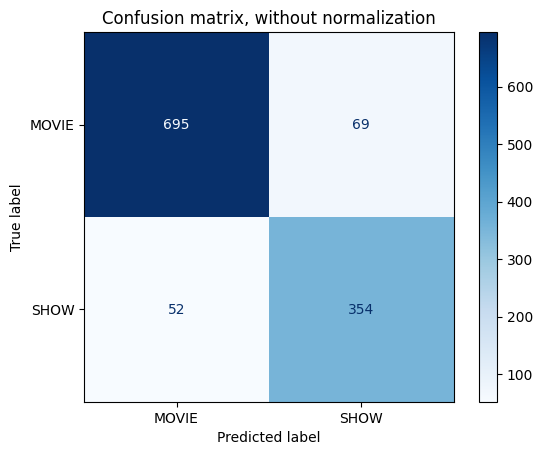

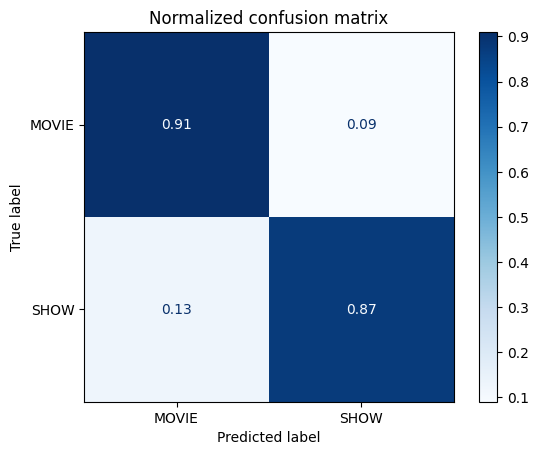

In [125]:
confusin_pre = confusion_matrix(y_test,y_pred_pre)
print('confudion matrix score is:',confusin_pre)


titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_pre,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [126]:
recall = recall_score(y_test,y_pred_pre,average='macro')
print(f'recall score is: {recall}')
#בכמה מהמבחן הצלחנו להצליח ולפגוע 

recall score is: 0.8908035230701777


In [127]:
F_measure = f1_score(y_test,y_pred_pre,average='macro')
print('f_measure score is:',F_measure)
#ממוצע של הריקול ולפריסיזן

f_measure score is: 0.8869807978323816


In [128]:
print(classification_report(y_test,y_pred_pre))

              precision    recall  f1-score   support

       MOVIE       0.93      0.91      0.92       764
        SHOW       0.84      0.87      0.85       406

    accuracy                           0.90      1170
   macro avg       0.88      0.89      0.89      1170
weighted avg       0.90      0.90      0.90      1170



feature importance

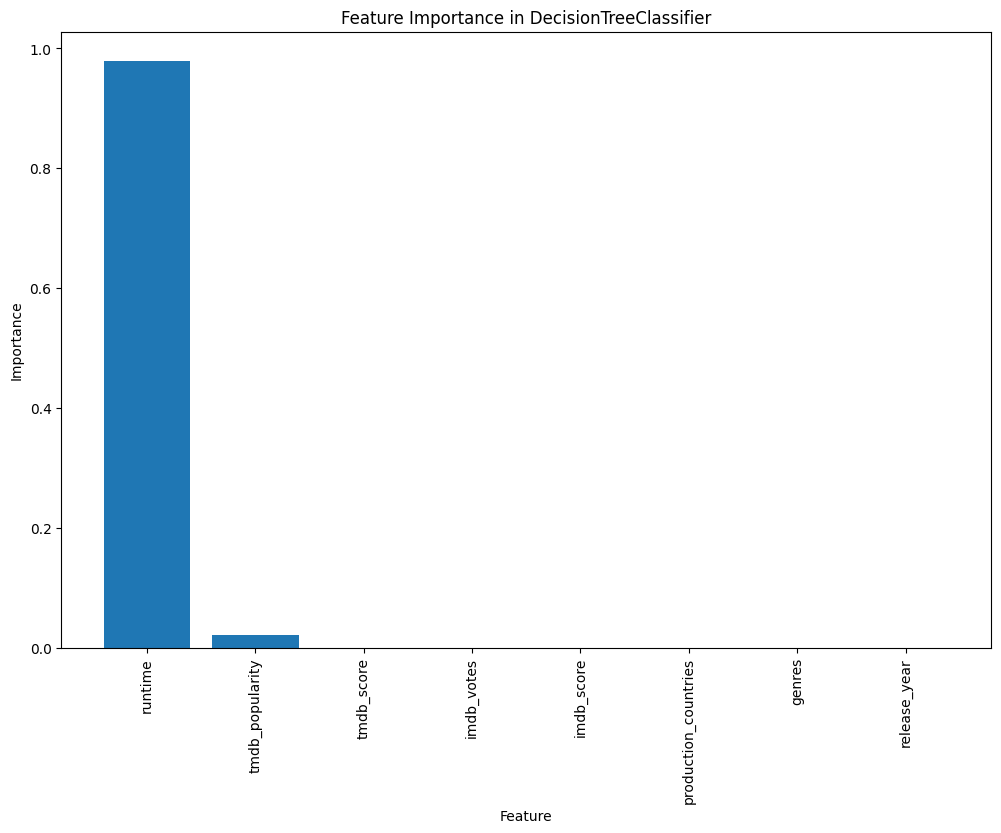

In [129]:
importance_clf = clf_pre.feature_importances_

indices = np.argsort(importance_clf)[::-1]

plt.figure(figsize=(12,8))
plt.bar(range(X_train.shape[1]),importance_clf[indices])
plt.xticks(range(X_train.shape[1]),X_train.columns[indices],rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in DecisionTreeClassifier')
plt.show()


random forest model

In [130]:
X_rf = df.iloc[:,1:]
Y_rf = df.iloc[:,:1]
class_names = ['MOVIE','SHOW']
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, Y_rf, test_size=0.2,random_state=42)


In [131]:
Rf_pre = RandomForestClassifier(max_depth=2,random_state=42)
Rf_pre.fit(X_rf_train,y_rf_train)

/var/folders/sh/3c77gz0j55vb45wgw4_kj4xr0000gn/T/ipykernel_56402/988167688.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Rf_pre.fit(X_rf_train,y_rf_train)


RandomForestClassifier(max_depth=2, random_state=42)

find accuracy

In [132]:
y_rf_pred_pre = Rf_pre.predict(X_rf_test)
accuracy_pre = accuracy_score(y_rf_test, y_rf_pred_pre)
print('Accuracy with pre-pruning:', accuracy_pre)

Accuracy with pre-pruning: 0.9051282051282051


find precision_score

In [133]:
precision_rf_pre = precision_score(y_rf_test,y_rf_pred_pre,average='macro')
print('precision_score with pre-pruning:', precision_rf_pre)

precision_score with pre-pruning: 0.8942253255331194


find confusion_matrix

confudion matrix score is: [[705  59]
 [ 52 354]]
Confusion matrix, without normalization
[[705  59]
 [ 52 354]]
Normalized confusion matrix
[[0.92277487 0.07722513]
 [0.12807882 0.87192118]]


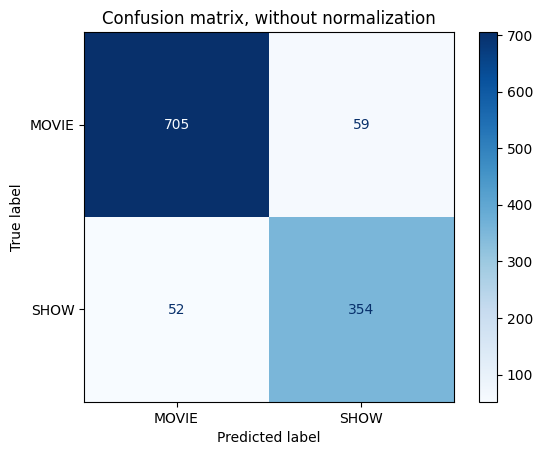

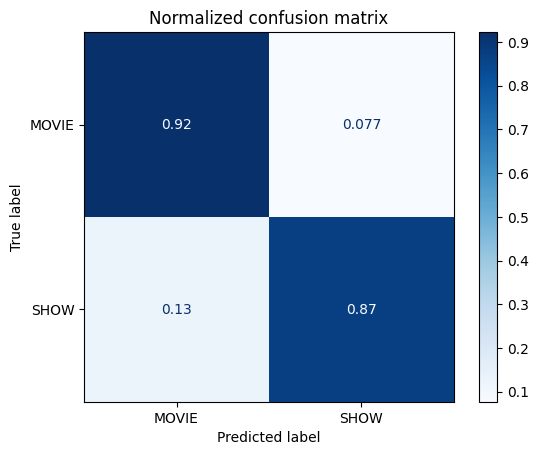

In [134]:
confusin_rf_pre = confusion_matrix(y_rf_test,y_rf_pred_pre)
print('confudion matrix score is:',confusin_rf_pre)


titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        Rf_pre,
        X_rf_test,
        y_rf_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

find recall score

In [135]:
recall_rf = recall_score(y_rf_test,y_rf_pred_pre,average='macro')
print(f'recall score is: {recall_rf}')

recall score is: 0.8973480256879788


find f1_score

In [136]:
F_rf_measure = f1_score(y_rf_test,y_rf_pred_pre,average='macro')
print('f_measure score is:',F_rf_measure)

f_measure score is: 0.8957452803606649


classification report

In [137]:

print(classification_report(y_rf_test,y_rf_pred_pre))

              precision    recall  f1-score   support

       MOVIE       0.93      0.92      0.93       764
        SHOW       0.86      0.87      0.86       406

    accuracy                           0.91      1170
   macro avg       0.89      0.90      0.90      1170
weighted avg       0.91      0.91      0.91      1170



download file

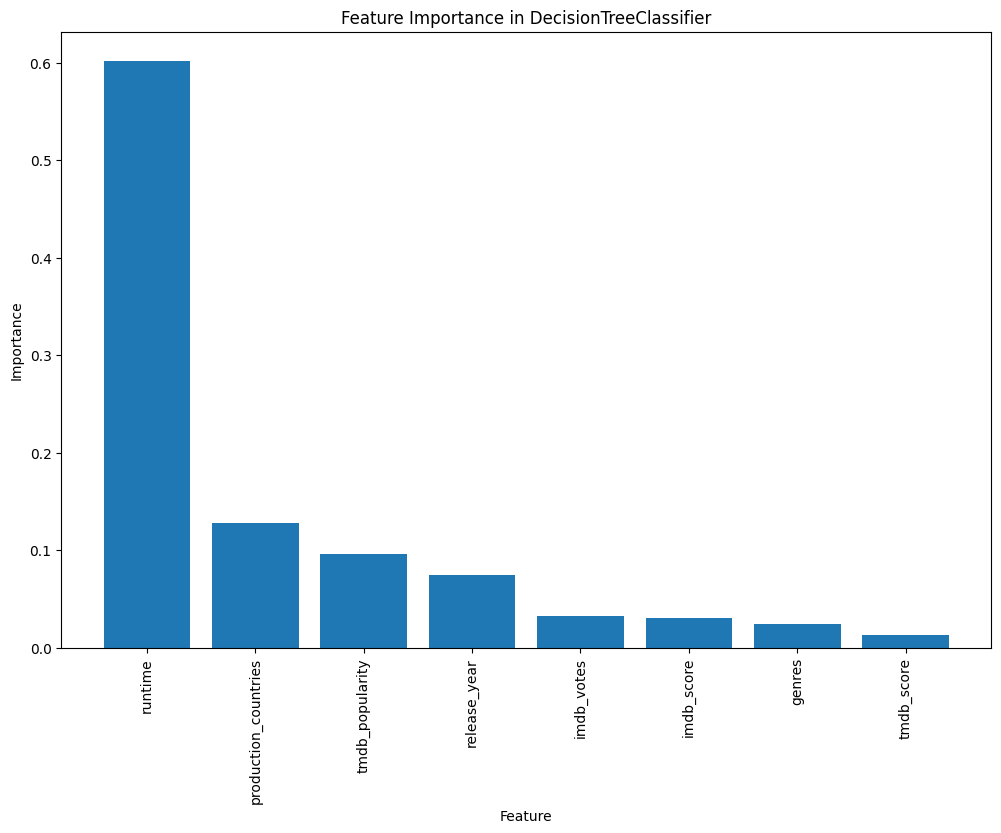

In [138]:
importance_clf = Rf_pre.feature_importances_

indices = np.argsort(importance_clf)[::-1]

plt.figure(figsize=(12,8))
plt.bar(range(X_rf_train.shape[1]),importance_clf[indices])
plt.xticks(range(X_rf_train.shape[1]),X_rf_train.columns[indices],rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in DecisionTreeClassifier')
plt.show()

In [139]:
# df.to_csv('/Users/jonatanbuga/Desktop/software engineering/2st year/כריית נתונים/FinalProject/titles_model_discationTree2.csv', index=False, encoding='utf-8-sig')


KNN model

split data to train test

In [140]:
X_knn = df.iloc[:,1:]
Y_knn = df.iloc[:,:1]
class_names = ['MOVIE','SHOW']
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, Y_knn, test_size=0.2,random_state=42)

In [141]:
knn_pre= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
knn_pre.fit(X_knn_train, y_knn_train) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

predict result

In [142]:
y_knn_train_pred = knn_pre.predict(X_knn_train)
y_knn_test_pred = knn_pre.predict(X_knn_test)

In [143]:
y_knn_pred_pre = knn_pre.predict(X_knn_test)
accuracy_knn_pre = accuracy_score(y_knn_test, y_knn_pred_pre)
print('Accuracy with pre-pruning:', accuracy_pre)

Accuracy with pre-pruning: 0.9051282051282051


In [144]:
precision_knn_pre = precision_score(y_knn_test,y_knn_pred_pre,average='macro')
print('precision_score with pre-pruning:', precision_knn_pre)

precision_score with pre-pruning: 0.8798076923076923


confudion matrix score is: [[696  68]
 [ 58 348]]
Confusion matrix, without normalization
[[696  68]
 [ 58 348]]
Normalized confusion matrix
[[0.91099476 0.08900524]
 [0.14285714 0.85714286]]


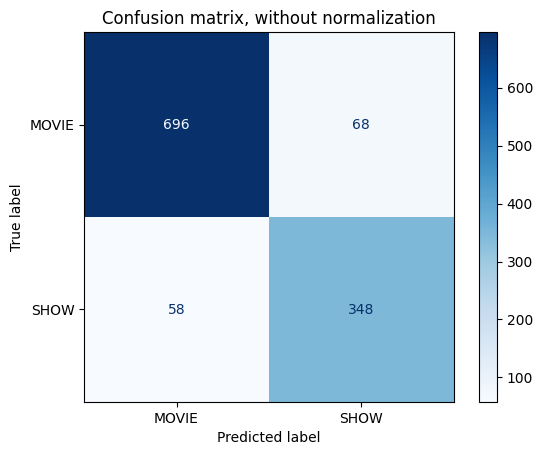

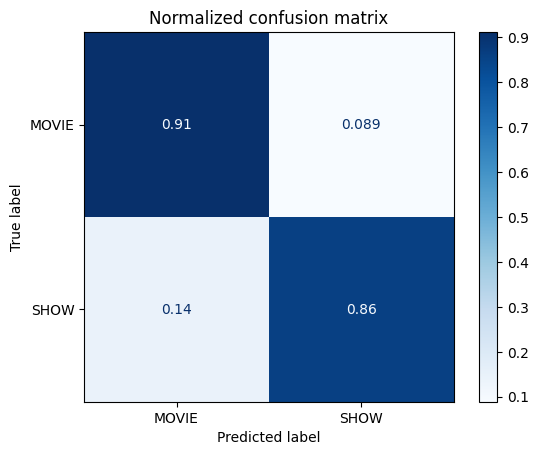

In [145]:
confusin_knn_pre = confusion_matrix(y_knn_test,y_knn_pred_pre)
print('confudion matrix score is:',confusin_knn_pre)


titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        knn_pre,
        X_knn_test,
        y_knn_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [146]:
recall_knn = recall_score(y_knn_test,y_knn_pred_pre,average='macro')
print(f'recall score is: {recall_knn}')

recall score is: 0.8840688107703814


In [147]:
F_knn_measure = f1_score(y_knn_test,y_knn_pred_pre,average='macro')
print('f_measure score is:',F_knn_measure)

f_measure score is: 0.8818556879489916


In [148]:
print(classification_report(y_knn_test,y_knn_pred_pre))

              precision    recall  f1-score   support

       MOVIE       0.92      0.91      0.92       764
        SHOW       0.84      0.86      0.85       406

    accuracy                           0.89      1170
   macro avg       0.88      0.88      0.88      1170
weighted avg       0.89      0.89      0.89      1170



download file

In [149]:
# df.to_csv('/Users/jonatanbuga/Desktop/software engineering/2st year/כריית נתונים/FinalProject/titles_model_knn1.csv', index=False, encoding='utf-8-sig')


k-means cluster

In [155]:
def showEvaluationMeasures(my_test,my_pred):
    accuracy_kmeans_pre = accuracy_score(my_test,my_pred)
    result = classification_report(my_test,my_pred)
    conf = confusion_matrix(my_test,my_pred)

    print(f"accuracy for k-means :{accuracy_kmeans_pre}\n")
    print(f"confution matrix is :{conf}\n")
    print(f"result:{result}")
    



In [156]:

# Convert column values to binary (0 and 1)
column_values_test = []
for val in y_test['type']:
    if val == 'MOVIE':
        column_values_test.append(1)
    else:
        column_values_test.append(0)
column_values_train = []
for val in y_train['type']:
    if val == 'MOVIE':
        column_values_train.append(1)
    else:
        column_values_train.append(0)
# Reshape the data to have a single feature (required for K-means)
column_values_test = np.array(column_values_test).reshape(-1, 1)
column_values_train = np.array(column_values_train).reshape(-1, 1)
# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42 ,max_iter=100)
kmeans.fit(X_train)

X_train['Kmeans_cluster'] = kmeans.labels_
X_train['real value'] = column_values_train

print("train set evaluation:\n")
showEvaluationMeasures(X_train['real value'],X_train['Kmeans_cluster'])

kmeans.fit(X_test)

X_test['Kmeans_cluster'] = kmeans.labels_
X_test['real value'] = column_values_test

print("train set evaluation:\n")
showEvaluationMeasures(X_test['real value'],X_test['Kmeans_cluster'])







/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


train set evaluation:

accuracy for k-means :0.3638888888888889

confution matrix is :[[1699    1]
 [2976    4]]

result:              precision    recall  f1-score   support

           0       0.36      1.00      0.53      1700
           1       0.80      0.00      0.00      2980

    accuracy                           0.36      4680
   macro avg       0.58      0.50      0.27      4680
weighted avg       0.64      0.36      0.20      4680

train set evaluation:

accuracy for k-means :0.3487179487179487

confution matrix is :[[406   0]
 [762   2]]

result:              precision    recall  f1-score   support

           0       0.35      1.00      0.52       406
           1       1.00      0.00      0.01       764

    accuracy                           0.35      1170
   macro avg       0.67      0.50      0.26      1170
weighted avg       0.77      0.35      0.18      1170

